# Data Science Capstone Project
Author: Vitaly Kamentsev

## Project Summary
Aim of this project is to answer these questions:
1.	Take some particular cuisine as a parameter and collect data of its presence in main cities of Europe.
2.	Detect geographical trends.
3.	Compare popularity of ethnic cuisines around Europe.


## Methodology
1.	Download wiki table of largest cities of Europe, extract it and build dataset of cities and its population.
2.	Enrich the dataset with latitude and longitude of each city with help of Google Geocoding API.
3.	For each city in the list extract list of venues of specific category (for example, Turkish Restaurants).
4.	Merge Cities and Venues datasets, group and clean to get statistics by city.
5.	Normalize statistics by city population.
6.	Make visualization on Europe map.

In [ ]:
!pip install folium
!pip install geocoder 
!pip install BeautifulSoup4

     |████████████████████████████████| 92kB 2.9MB/s eta 0:00:011
     |████████████████████████████████| 17.3MB 98kB/s s eta 0:00:01�███████▎      | 13.7MB 9.1MB/s eta 0:00:01
     |████████████████████████████████| 102kB 686kB/s ta 0:00:011
     |████████████████████████████████| 829kB 5.0MB/s eta 0:00:01
     |████████████████████████████████| 81kB 7.1MB/s eta 0:00:011
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
     |████████████████████████████████| 102kB 3.2MB/s ta 0:00:011


In [1]:
import os
import pandas as pd
import requests
import folium
from folium.plugins import HeatMap
import numpy as np
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt

## 1. Extract list of biggest cities of Europe from wiki page

In [2]:
columns = ['cityName', 'population']
cities = pd.DataFrame(columns=columns)

#parse wiki page
r = requests.get('https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits')
soup = bs(r.text, 'html.parser')
table = soup.find('table', class_='wikitable sortable')
#table
i = 0
for td in table.find_all('td'):
    if i == 1:
        name = td.find('a').text.rstrip()
        #print(name)
    elif i == 3:
        population = td.text.rstrip()
        #print(population)
    elif i == 8:
        cities = cities.append(
                {'cityName': name,
                'population': int(population.replace(',', ''))},
                ignore_index=True
            )        
        i = - 1
    i += 1
    
cities.head(10)
#cities.dtypes

,cityName,population
0,Istanbul,15029231
1,Moscow,13197596
2,London,9126366
3,Saint Petersburg,5381736
4,Berlin,3748148
5,Madrid,3223334
6,Kyiv,2950819
7,Rome,2857321
8,Paris,2140526
9,Bucharest,2106144


## 2. Get coordinates of cities via Google API

In [101]:
GOOGLE_API_KEY='' #your google api key

In [4]:
#@title 
def getCityCoordinates(city):
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(city, GOOGLE_API_KEY)
    result = requests.get(url).json()["results"][0]['geometry']['location']
    return result

In [5]:
latlng = getCityCoordinates('London')
latlng['lat']

51.5073509

In [10]:
#get cooridnates
for index, row in cities.iterrows():
    print(row['cityName'])
    latlng = getCityCoordinates(row['cityName'])
    cities.at[index, 'latitude'] = latlng['lat']
    cities.at[index, 'longitude'] = latlng['lng']

cities.head(10)

Istanbul
Moscow
London
Saint Petersburg
Berlin
Madrid
Kyiv
Rome
Paris
Bucharest
Minsk
Hamburg
Vienna
Warsaw
Budapest
Barcelona
Kharkiv
Munich
Milan
Prague
Nizhny Novgorod
Kazan
Sofia
Birmingham
Brussels
Samara
Belgrade
Ufa
Rostov-on-Don
Cologne
Voronezh
Perm
Volgograd
Odessa
Krasnodar


,cityName,population,latitude,longitude,count
0,Istanbul,15029231,41.008238,28.978359,3.0
1,Moscow,13197596,55.755826,37.617300,0.0
2,London,9126366,51.507351,-0.127758,2.0
3,Saint Petersburg,5381736,59.934280,30.335099,1.0
4,Berlin,3748148,52.520007,13.404954,0.0
5,Madrid,3223334,40.416775,-3.703790,0.0
6,Kyiv,2950819,50.450100,30.523400,1.0
7,Rome,2857321,41.902783,12.496365,0.0
8,Paris,2140526,48.856614,2.352222,0.0
9,Bucharest,2106144,44.426767,26.102538,0.0


## 3. Get restaurants of specific national cuisine from Foursquare

In [73]:
CATEGORY = '4bf58dd8d48988d150941735' # Spanish

In [74]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 200

In [99]:
def getVenuesByCategory(city, latitude, longitude, categoryId, radius=1000):
    venues_list = []
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude,
        categoryId,
        radius, 
        LIMIT)
    
    #print(url)
    try:
        results = requests.get(url).json()["response"]['venues']
        venues_list.append([(
            city,
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])
        #print(venues_list)
        venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    except:
        venues = pd.DataFrame(columns = ['cityName', 'venueName', 'latitude', 'longitude', 'category'])
        
    return(venues)

In [76]:
#columns = ['cityName', 'population', 'cityLatitude', 'cityLongitude', 'venueName', 'venueLatitude', 'venueLongitude', 'category']
venues = pd.DataFrame()

for index, row in cities.iterrows():
    print(row['cityName'], end = ': ')
    city_venues = getVenuesByCategory(row['cityName'], row['latitude'], row['longitude'], CATEGORY, 3000)
    print(len(city_venues))
    venues = venues.append(city_venues, ignore_index = True)

Istanbul: 17
Moscow: 18
London: 50
Saint Petersburg: 21
Berlin: 50
Madrid: 50
Kyiv: 3
Rome: 14
Paris: 50
Bucharest: 16
Minsk: 2
Hamburg: 49
Vienna: 31
Warsaw: 35
Budapest: 28
Barcelona: 50
Kharkiv: 1
Munich: 26
Milan: 35
Prague: 22
Nizhny Novgorod: 0
Kazan: 0
Sofia: 17
Birmingham: 3
Brussels: 49
Samara: 0
Belgrade: 2
Ufa: 0
Rostov-on-Don: 1
Cologne: 43
Voronezh: 0
Perm: 10
Volgograd: 1
Odessa: 1
Krasnodar: 1


In [77]:
columns = ['cityName', 'venueName', 'venueLatitude', 'venueLongitude', 'category']
venues.columns = columns
venues.head(10)

,cityName,venueName,venueLatitude,venueLongitude,category
0,Istanbul,Nars Brasserie,41.008372,28.977673,Spanish Restaurant
1,Istanbul,Huzur Cafe&Restaurant,41.008225,28.976916,Tapas Restaurant
2,Istanbul,Bara La Afrika,41.030604,28.973967,Cocktail Bar
3,Istanbul,Markus Tavern,41.031919,28.979551,Tapas Restaurant
4,Istanbul,Halit usta egzotik yemekler,41.006458,28.955869,Tapas Restaurant
5,Istanbul,Krependeki Kadir'in Yeri,41.034804,28.977635,Seafood Restaurant
6,Istanbul,Que Tal Tapas Bar,41.027993,28.973722,Tapas Restaurant
7,Istanbul,Oz Cafe,41.005945,28.980680,Tapas Restaurant
8,Istanbul,citiespera,41.031030,28.974296,Tapas Restaurant
9,Istanbul,Mayhoş,41.032168,28.983009,Burrito Place


In [78]:
venues.shape

(696, 5)

In [79]:
cities.to_pickle('cities.pck')
venues.to_pickle('venues.pck')

## 4. Group and merge City data and venue stats

In [43]:
cities = pd.read_pickle('cities.pck')
venues = pd.read_pickle('venues.pck')

In [80]:
#cities.drop(columns = ['count'], inplace = True)
cities.head()

,cityName,population,latitude,longitude
0,Istanbul,15029231,41.008238,28.978359
1,Moscow,13197596,55.755826,37.617300
2,London,9126366,51.507351,-0.127758
3,Saint Petersburg,5381736,59.934280,30.335099
4,Berlin,3748148,52.520007,13.404954


In [81]:
venues_grouped = venues.groupby(['cityName']).size().to_frame()
venues_grouped.reset_index(inplace = True)
venues_grouped.columns = ['cityName', 'count']

venues_grouped.head(10)

,cityName,count
0,Barcelona,50
1,Belgrade,2
2,Berlin,50
3,Birmingham,3
4,Brussels,49
5,Bucharest,16
6,Budapest,28
7,Cologne,43
8,Hamburg,49
9,Istanbul,17


In [82]:
cities_merged = pd.merge(left = cities, right = venues_grouped, how = 'left', on = 'cityName')

In [83]:
cities_merged.fillna(value = {'count': 0}, inplace = True)
cities_merged.head(10)

,cityName,population,latitude,longitude,count
0,Istanbul,15029231,41.008238,28.978359,17.0
1,Moscow,13197596,55.755826,37.617300,18.0
2,London,9126366,51.507351,-0.127758,50.0
3,Saint Petersburg,5381736,59.934280,30.335099,21.0
4,Berlin,3748148,52.520007,13.404954,50.0
5,Madrid,3223334,40.416775,-3.703790,50.0
6,Kyiv,2950819,50.450100,30.523400,3.0
7,Rome,2857321,41.902783,12.496365,14.0
8,Paris,2140526,48.856614,2.352222,50.0
9,Bucharest,2106144,44.426767,26.102538,16.0


## 5. Europe map with respective data

In [84]:
#latlng = getCityCoordinates('Europe')
europe_center = ('50.2806432', '14.4009044')

In [86]:
europe_map = folium.Map(location = europe_center, zoom_start = 5)

for lat, lng, name, count in zip(cities_merged['latitude'], cities_merged['longitude'], cities_merged['cityName'], cities_merged['count']):
    label = '{}, {}'.format(name, int(count))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=count,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.5,
        parse_html=False).add_to(europe_map)  

#HeatMap(latlons).add_to(europe_map)

europe_map

## Additional Visualizations

In [88]:
!pip install wordcloud

In [89]:
from wordcloud import WordCloud, STOPWORDS

In [90]:
def makeCityWordCloud(index):
  venues = getVenuesByCategory(cities.at[index, 'cityName'], cities.at[index, 'latitude'], cities.at[index, 'longitude'], '4d4b7105d754a06374d81259', 2000) # All food 
  venues.columns = ['cityName', 'venueName', 'venueLatitude', 'venueLongitude', 'category']
  words = venues.loc[venues['category'].str.contains(' Restaurant')]['category'].str.rstrip('Restaurant')
  
  wc = WordCloud(
    background_color = 'white',
    max_words=2000,
    stopwords=set(words)
  )

  # generate the word cloud
  wc.generate(words.to_string())
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()

Istanbul:


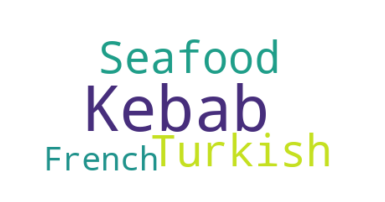

Moscow:


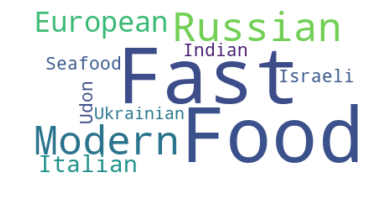

London:


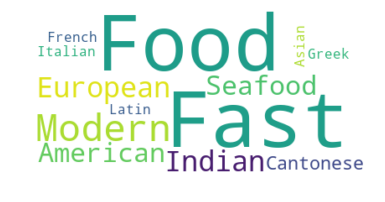

Saint Petersburg:


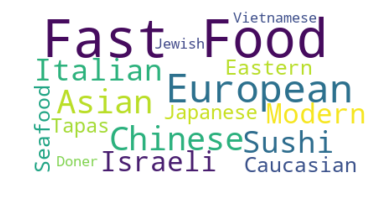

Berlin:


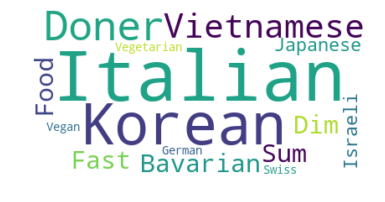

Madrid:


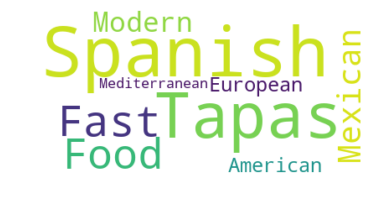

Kyiv:


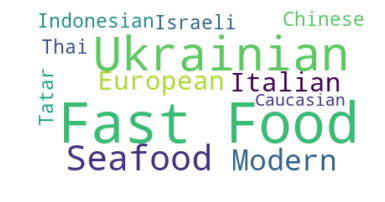

Rome:


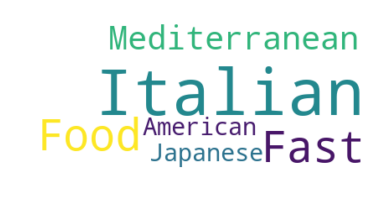

Paris:


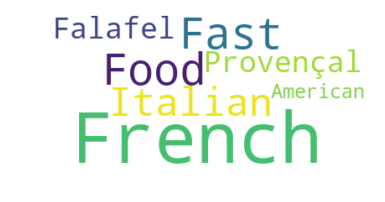

Bucharest:


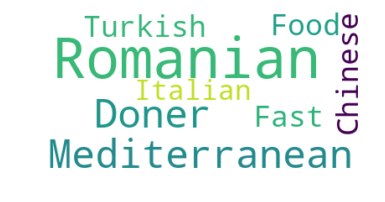

Minsk:


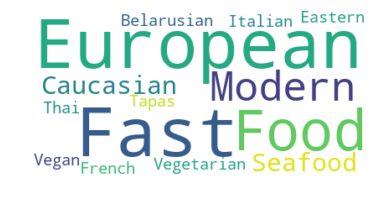

Hamburg:


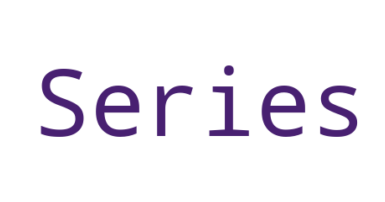

Vienna:


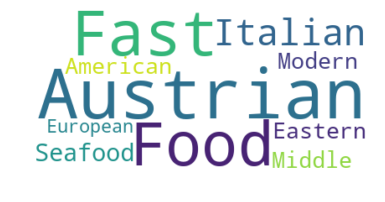

Warsaw:


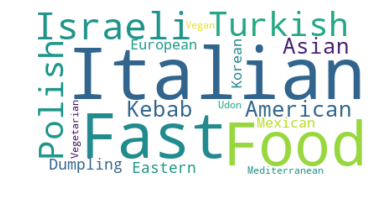

Budapest:


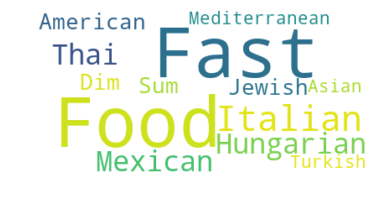

Barcelona:


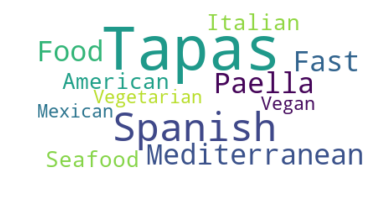

Kharkiv:


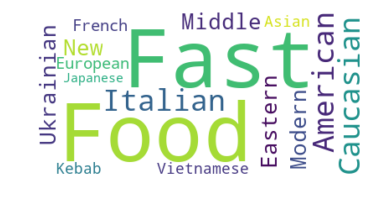

Munich:


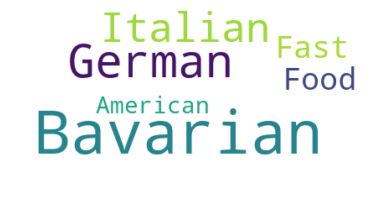

Milan:


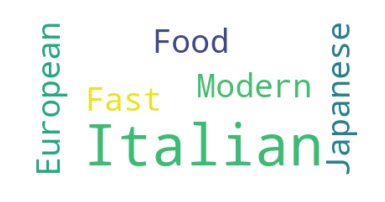

Prague:


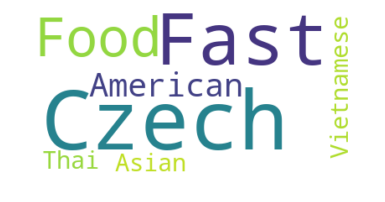

Nizhny Novgorod:


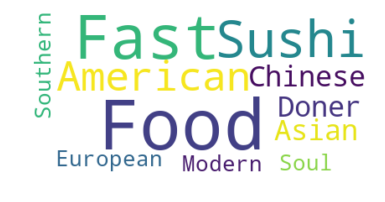

Kazan:


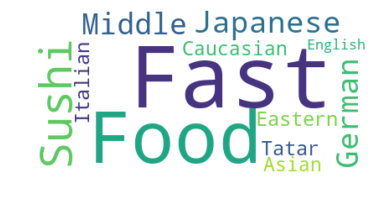

Sofia:


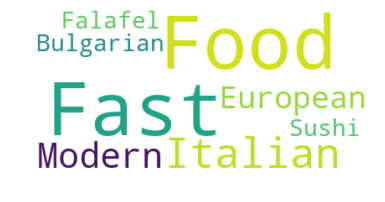

Birmingham:


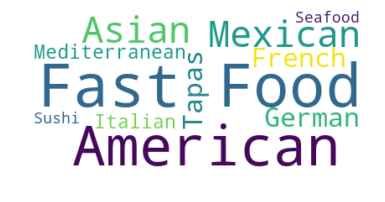

Brussels:


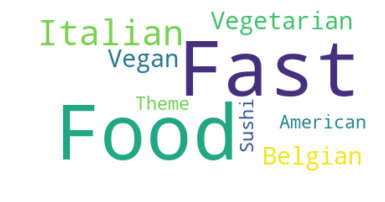

Samara:


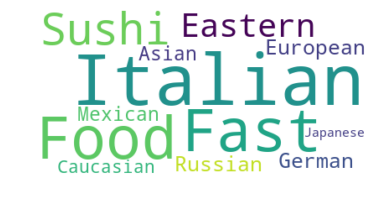

Belgrade:


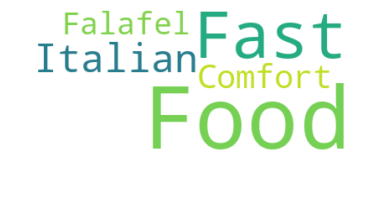

Ufa:


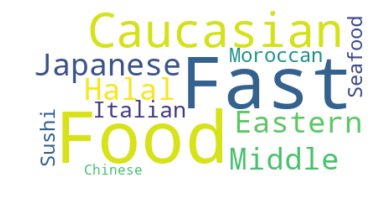

Rostov-on-Don:


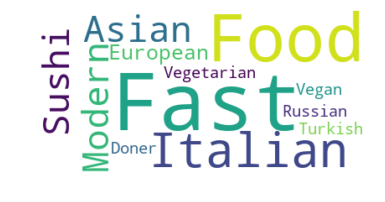

Cologne:


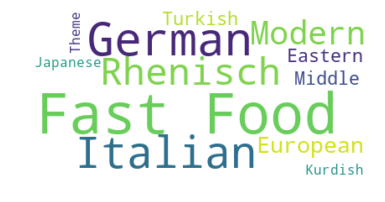

Voronezh:


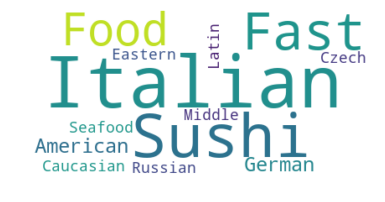

Perm:


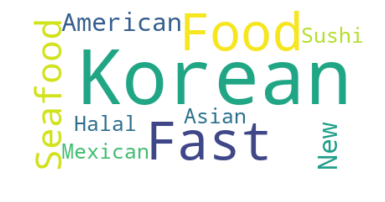

Volgograd:


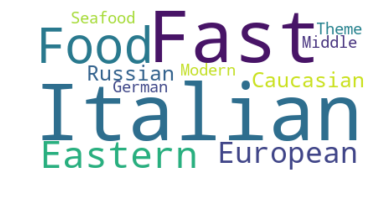

Odessa:


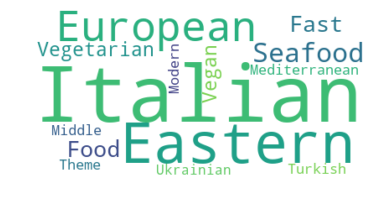

Krasnodar:


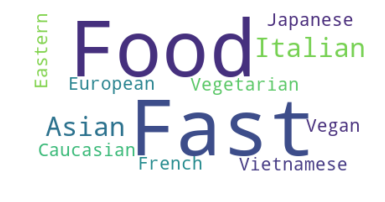

In [100]:
for index, row in cities.iterrows():
    print(row['cityName'] + ':')
    makeCityWordCloud(index) 